In [1]:
import librosa
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from transformers import WhisperTokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-large", language="English", task="transcribe")
print(tokenizer.vocab_size)

50258


In [3]:
metadata=pd.read_csv("train.csv",encoding='latin-1')
metadata.head()

,Dataset,FileName,text,label2a,Starting,Ending
0,CMU-MOSEI,jqutn5ou8_0_9,"We have ETF updates now, we have intraday upda...",0,75.131,81.618
1,CMU-MOSEI,72017_2,"And it's basically about , it's about Dracula...",0,3.653,12.056
2,CMU-MOSEI,248400_4,"Nevertheless, the Last Crusade returns to the...",0,13.74,23.271
3,CMU-MOSEI,zv0Jl4TIQDc_5,This is another exercise where we're going to ...,0,29.764,35.633
4,CMU-MOSEI,jjbOD6u7V34_16,They're going to kill us as soon as you leave....,0,77.755,112.508


In [4]:
metadata['label2a'].value_counts()

0    8861
1    2963
Name: label2a, dtype: int64

In [5]:
metadata['vector'] = metadata['text'].apply(lambda text: tokenizer(text).input_ids)

In [6]:
metadata.head()

,Dataset,FileName,text,label2a,Starting,Ending,vector
0,CMU-MOSEI,jqutn5ou8_0_9,"We have ETF updates now, we have intraday upda...",0,75.131,81.618,"[4360, 362, 37436, 9205, 586, 11, 321, 362, 56..."
1,CMU-MOSEI,72017_2,"And it's basically about , it's about Dracula...",0,3.653,12.056,"[400, 309, 311, 1936, 466, 3182, 309, 311, 466..."
2,CMU-MOSEI,248400_4,"Nevertheless, the Last Crusade returns to the...",0,13.74,23.271,"[26554, 11, 220, 3322, 5264, 34484, 762, 11247..."
3,CMU-MOSEI,zv0Jl4TIQDc_5,This is another exercise where we're going to ...,0,29.764,35.633,"[5723, 307, 1071, 5380, 689, 321, 434, 516, 22..."
4,CMU-MOSEI,jjbOD6u7V34_16,They're going to kill us as soon as you leave....,0,77.755,112.508,"[8829, 434, 516, 220, 1353, 1961, 505, 382, 23..."


In [7]:
print(len(metadata['vector']))
length=[]
for i in range(len(metadata['vector'])):
    length.append(len(metadata['vector'][i]))

print(np.amax(length))


11824
818


In [8]:
def vectorize(text):
    temp_array=tokenizer(text).input_ids
    padding_value = 0  # Set the value to be used for padding
    max_length = 818

    my_array = np.array(temp_array)
    padded_array = np.pad(my_array, (0, max_length - len(my_array)), mode='constant', constant_values=padding_value)  
    return padded_array

In [9]:
metadata['paded_vector'] = metadata['text'].apply(lambda text: vectorize(text))
metadata.head()

,Dataset,FileName,text,label2a,Starting,Ending,vector,paded_vector
0,CMU-MOSEI,jqutn5ou8_0_9,"We have ETF updates now, we have intraday upda...",0,75.131,81.618,"[4360, 362, 37436, 9205, 586, 11, 321, 362, 56...","[4360, 362, 37436, 9205, 586, 11, 321, 362, 56..."
1,CMU-MOSEI,72017_2,"And it's basically about , it's about Dracula...",0,3.653,12.056,"[400, 309, 311, 1936, 466, 3182, 309, 311, 466...","[400, 309, 311, 1936, 466, 3182, 309, 311, 466..."
2,CMU-MOSEI,248400_4,"Nevertheless, the Last Crusade returns to the...",0,13.74,23.271,"[26554, 11, 220, 3322, 5264, 34484, 762, 11247...","[26554, 11, 220, 3322, 5264, 34484, 762, 11247..."
3,CMU-MOSEI,zv0Jl4TIQDc_5,This is another exercise where we're going to ...,0,29.764,35.633,"[5723, 307, 1071, 5380, 689, 321, 434, 516, 22...","[5723, 307, 1071, 5380, 689, 321, 434, 516, 22..."
4,CMU-MOSEI,jjbOD6u7V34_16,They're going to kill us as soon as you leave....,0,77.755,112.508,"[8829, 434, 516, 220, 1353, 1961, 505, 382, 23...","[8829, 434, 516, 220, 1353, 1961, 505, 382, 23..."


In [10]:
# X_train, X_test, y_train, y_test = train_test_split(metadata['paded_vector'],metadata['label2a'],test_size=0.2)

In [11]:
transcriptions=metadata['paded_vector'].tolist()
class_labels=metadata['label2a'].tolist()

In [12]:
print(np.shape(transcriptions))
print(np.shape(class_labels))

X_train = transcriptions[:9460]
Y_train = class_labels[:9460]
X_test = transcriptions[9460:]
Y_test = class_labels[9460:]


print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))

(11824, 818)
(11824,)
(9460, 818)
(9460,)
(2364, 818)
(2364,)


In [15]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test, dtype=tf.int64)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.int64)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int64)

In [16]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import MaxPooling1D, Embedding, Conv1D
from keras.layers import *

In [17]:
cnn_model = Sequential()

embedding_layer = Embedding(50259,818, input_length=818)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(32, 3, activation='relu',padding='same'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Dense(16, activation='relu'))
cnn_model.add(Dense(8, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(2, activation='softmax'))

In [18]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 818, 818)          41111862  
                                                                 
 conv1d (Conv1D)             (None, 818, 32)           78560     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 409, 32)          0         
 )                                                               
                                                                 
 dense (Dense)               (None, 409, 16)           528       
                                                                 
 dense_1 (Dense)             (None, 409, 8)            136       
                                                                 
 flatten (Flatten)           (None, 3272)              0         
                                                        

In [19]:
cnn_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [20]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='cnn_text_model.hdf5', 
                               monitor='val_accuracy', 
                               verbose=1, 
                               save_best_only=True)


In [21]:
model= cnn_model.fit(X_train, Y_train, batch_size=16, epochs=3,validation_data=(X_test, Y_test), callbacks=[checkpointer])

Epoch 1/3
592/592 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.8995
Epoch 1: val_accuracy improved from -inf to 0.73393, saving model to cnn_text_model.hdf5
592/592 [==============================] - 578s 974ms/step - loss: 0.2633 - accuracy: 0.8995 - val_loss: 0.8893 - val_accuracy: 0.7339
Epoch 2/3
592/592 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9801
Epoch 2: val_accuracy did not improve from 0.73393
592/592 [==============================] - 576s 973ms/step - loss: 0.0547 - accuracy: 0.9801 - val_loss: 0.8913 - val_accuracy: 0.7128
Epoch 3/3
592/592 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9964
Epoch 3: val_accuracy did not improve from 0.73393
592/592 [==============================] - 596s 1s/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 1.5038 - val_accuracy: 0.7267


In [22]:
loaded_model = tf.keras.models.load_model("cnn_text_model.hdf5")

In [23]:
y_test_pred=loaded_model.predict(X_test)

74/74 [==============================] - 6s 80ms/step


In [24]:
y_prediction = loaded_model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis = 1)
print(y_prediction)

74/74 [==============================] - 6s 75ms/step
[1 0 0 ... 0 0 0]


In [27]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score

result = confusion_matrix(Y_test, y_prediction , normalize='pred')
score=f1_score(Y_test, y_prediction)
print(result)
print(score)

[[0.76338673 0.62569832]
 [0.23661327 0.37430168]]
0.17562254259501964


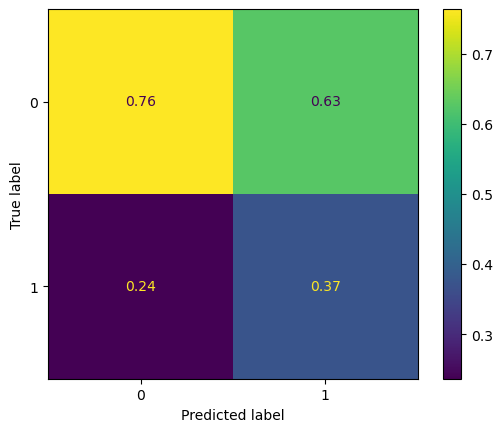

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot()

In [29]:
Y_test

<tf.Tensor: shape=(2364,), dtype=int64, numpy=array([1, 0, 0, ..., 0, 1, 0], dtype=int64)>

In [30]:
model_class = tf.keras.models.load_model("cnn_text_model.hdf5")

In [32]:
#X_test, Y_test
pred = []
ori = []
for i in range(len(X_test)):
    seq = X_test[i]
    #print(np.shape(seq))
    seq = np.reshape(seq, (1, 818))
    #print(np.shape(seq))
    pred.append(np.argmax(model_class.predict(seq)))
    ori.append(Y_test[i].numpy())


1/1 [==============================] - 0s 32ms/step


In [33]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
classification_report(ori, pred, target_names=target_names)
result = confusion_matrix(ori, pred)
print(result)

[[1668  112]
 [ 517   67]]


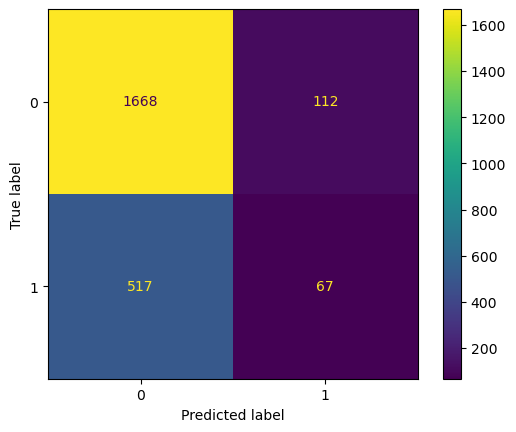

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot()

In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, Y_sm = smote.fit_resample(transcriptions, class_labels)

In [40]:
print(len(Y_sm))
print(len(X_sm))

17722
17722


In [43]:
17722-(17722/100)*20

14177.6

In [44]:
print(np.shape(X_sm))
print(np.shape(Y_sm))

X_train = X_sm[:14177]
Y_train = Y_sm[:14177]
X_test = X_sm[14177:]
Y_test = Y_sm[14177:]


print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))

(17722, 818)
(17722,)
(14177, 818)
(14177,)
(3545, 818)
(3545,)


In [45]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test, dtype=tf.int64)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.int64)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int64)

In [66]:
len(Y_test)

3545

In [46]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='cnn_text_ov_model.hdf5', 
                               monitor='val_accuracy', 
                               verbose=1, 
                               save_best_only=True)


In [47]:
model_ov= cnn_model.fit(X_train, Y_train, batch_size=16, epochs=3,validation_data=(X_test, Y_test), callbacks=[checkpointer])

Epoch 1/3
887/887 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9424
Epoch 1: val_accuracy improved from -inf to 0.94274, saving model to cnn_text_ov_model.hdf5
887/887 [==============================] - 839s 945ms/step - loss: 0.1581 - accuracy: 0.9424 - val_loss: 0.1265 - val_accuracy: 0.9427
Epoch 2/3
887/887 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9871
Epoch 2: val_accuracy improved from 0.94274 to 0.97433, saving model to cnn_text_ov_model.hdf5
887/887 [==============================] - 821s 925ms/step - loss: 0.0352 - accuracy: 0.9871 - val_loss: 0.0620 - val_accuracy: 0.9743
Epoch 3/3
887/887 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9958
Epoch 3: val_accuracy did not improve from 0.97433
887/887 [==============================] - 825s 930ms/step - loss: 0.0129 - accuracy: 0.9958 - val_loss: 0.1580 - val_accuracy: 0.9532


In [48]:
loaded_ov_model = tf.keras.models.load_model("cnn_text_ov_model.hdf5")

In [50]:
y_test_pred=loaded_ov_model.predict(X_test)

111/111 [==============================] - 10s 88ms/step


In [67]:
y_prediction = loaded_ov_model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis = 1)
print(len(y_prediction))

111/111 [==============================] - 9s 77ms/step
3545


In [72]:
result = confusion_matrix(Y_test, y_prediction)
score=f1_score(Y_test, y_prediction)
print(result)
print(score)

[[   0    0]
 [  91 3454]]
0.9869981425917987


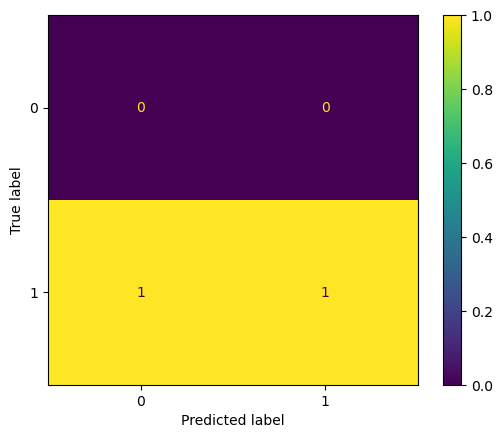

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot()

In [56]:
model_ov_class = tf.keras.models.load_model("cnn_text_ov_model.hdf5")

In [64]:
Y_test

<tf.Tensor: shape=(3545,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1], dtype=int64)>

In [57]:
#X_test, Y_test
pred = []
ori = []
for i in range(len(X_test)):
    seq = X_test[i]
    #print(np.shape(seq))
    seq = np.reshape(seq, (1, 818))
    #print(np.shape(seq))
    pred.append(np.argmax(model_ov_class.predict(seq)))
    ori.append(Y_test[i].numpy())


1/1 [==============================] - 0s 29ms/step


In [60]:
Y_test

<tf.Tensor: shape=(3545,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1], dtype=int64)>

In [61]:
target_names = ['class 0', 'class 1']
classification_report(ori, pred, target_names=target_names)
result = confusion_matrix(ori, pred)
print(result)

[[   0    0]
 [  91 3454]]


c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


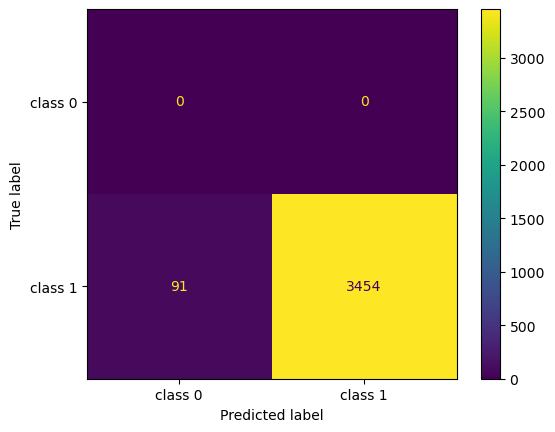

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix=result,display_labels=target_names)
disp.plot()